## Example of online analysis using Volpy

Complete pipeline for online processing using Volpy.
The demo demonstates the analysis of a sequence of files using the CaImAn online
algorithm. The steps include i) motion correction, ii) Neuronal segmentation by MaskR-CNN, iii) Volpy.

# Open libraries

In [3]:
import logging
try:
    if __IPYTHON__:
        # this is used for debugging purposes only. allows to reload classes when changed
        get_ipython().magic('load_ext autoreload')
        get_ipython().magic('autoreload 2')
except NameError:
    pass

logging.basicConfig(format=
                          "%(relativeCreated)12d [%(filename)s:%(funcName)20s():%(lineno)s] [%(process)d] %(message)s",
                    # filename="/tmp/caiman.log",
                    level=logging.INFO)

import numpy as np
import tifffile
import os
import h5py

import caiman as cm
import mesmerize_core as mescore
from caiman.source_extraction import cnmf, volpy
from caiman.source_extraction.volpy.volparams import volparams
from caiman.source_extraction.volpy.volpy import VOLPY
from caiman.source_extraction.volpy import pre_processing, utils
from caiman.summary_images import local_correlations_movie_offline
#from caiman.utils.utils import download_demo, download_model
import matplotlib.pyplot as plt


from fastplotlib import ImageWidget
from ipywidgets import VBox, IntSlider, Layout

C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_20292\1149004873.py:5: DeprecationWarning: `magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).
  get_ipython().magic('load_ext autoreload')


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_20292\1149004873.py:6: DeprecationWarning: `magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).
  get_ipython().magic('autoreload 2')


# First import data and set parameters for motion_correction

Complete pipeline for online processing using Volpy, but with motion correction and CNMF/CNMF_E separate instead of done simultaneously.

This allows to visualize if motion correction was well performed prior to start Volpy.

In [21]:
#Set data as a list
fnames = ["Z:/Data for optimizing Volpy/Positive dye/pAceR_500Hz_30mW_-2512+222-104_4x4binning_1/pAceR_500Hz_30mW_-2512+222-104_4x4binning_1_MMStack_Default.ome.tif",
         "Z:/Data for optimizing Volpy/Positive dye/pAceR_500Hz_30mW_-2512+222-104_5/pAceR_500Hz_30mW_-2512+222-104_5_MMStack_Default.ome.tif",
         "Z:/Data for optimizing Volpy/Positive dye/pAceR_500Hz_30mW_-2512+222-104_6/pAceR_500Hz_30mW_-2512+222-104_6_MMStack_Default.ome.tif",
         "Z:/Data for optimizing Volpy/Positive dye/pAceR_500Hz_30mW_-2512+222-104_7/pAceR_500Hz_30mW_-2512+222-104_7_MMStack_Default.ome.tif",
         "Z:/Data for optimizing Volpy/Positive dye/pAceR_500Hz_30mW_-2512+222-104_8/pAceR_500Hz_30mW_-2512+222-104_8_MMStack_Default.ome.tif",
         "Z:/Data for optimizing Volpy/Positive dye/pAceR_500Hz_30mW_-2512+222-104_9/pAceR_500Hz_30mW_-2512+222-104_9_MMStack_Default.ome.tif"]

if isinstance(fnames,str):
    fnames = [fnames]

for i in range(0,len(fnames)):
    if os.path.exists(fnames[i]) == False:
        logging.warning('File '+ str(i+1) + ': '+fnames[i] + ' does not exits! Please correct the filename.')

In [27]:
if isinstance(fnames,str):
    fnames = [fnames]
    ##############################################################################################################
#Set parameters
fr = 500                            # frame rate
gSig_filt = (13,13)                 #Gaussian filter size. It should normally be half the neuron size. Set it to none for 2-photon
pw_rigid = False                    #True if piece-wise motion correction should be used
strides = (96, 96)                  #Patch sizes in pixels.
overlaps = (24, 24)                 #Overlap between patches in pixels. This value normally does not have to be very high.
max_shifts_online = 20              #Maximum rigid shifts
max_deviation_rigid = 5            #Maximum deviation in pixels between rigid shifts and shifts of individual patches
border_nan = 'copy'                 #flag for allowing NaN in the boundaries. True allows NaN, whereas 'copy' copies the 
                                            #value of the nearest data point.
shifts_opencv = True                #flag for applying shifts using cubic interpolation (otherwise FFT)
init_batch = 500                    #initial batch 
ds_factor = 1                       #Spatial binning factor. Have in account that if spatial binning is used, all values above are unaltered.
normalize = False                   #Whether to normalize each frame prior to online processing. Set it to False for 2 photon

params_dict = {'fnames': fnames[0],
               'gSig_filt': gSig_filt,
               'pw_rigid': pw_rigid,
               'strides': strides,
               'overlaps': overlaps,
               'max_shifts_online': max_shifts_online,
               'max_deviation_rigid': max_deviation_rigid,
               'border_nan': border_nan,
               'shifts_opencv': shifts_opencv,
               'init_batch': init_batch,
               'ds_factor': ds_factor,
               'normalize': normalize}
opts = cnmf.params.CNMFParams(params_dict=params_dict)

nbits = np.float16                          #Number of bits in which to save final images as tiff files.
init_template = None                #If an initial template can be provided, this should be where to set this variable into 
                                           #the template 2D numpy array.
    
#Set parameters
opts = cnmf.params.CNMFParams(params_dict=params_dict)
cnm = cnmf.online_cnmf.OnACID(params=opts)  

     3439922 [params.py:                 set():976] [20292] Changing key fnames in group data from None to Z:/Data for optimizing Volpy/Positive dye/pAceR_500Hz_30mW_-2512+222-104_4x4binning_1/pAceR_500Hz_30mW_-2512+222-104_4x4binning_1_MMStack_Default.ome.tif
     3439924 [params.py:                 set():976] [20292] Changing key max_shifts_online in group online from 10 to 20
     3439927 [params.py:                 set():976] [20292] Changing key init_batch in group online from 200 to 500
     3439929 [params.py:                 set():976] [20292] Changing key gSig_filt in group motion from None to (13, 13)
     3439932 [params.py:                 set():976] [20292] Changing key overlaps in group motion from (32, 32) to (24, 24)
     3439934 [params.py:                 set():976] [20292] Changing key max_deviation_rigid in group motion from 3 to 5
     3443174 [params.py:                 set():976] [20292] Changing key fnames in group data from None to Z:/Data for optimizing Volpy/

# Motion correction

In [28]:
reuse_template = False
#save_dir = "Z:/Data for optimizing Volpy/Negative dye"
save_dir=None
MCfnames = fnames.copy()

for i in range(0,len(fnames)):
    cnm.params.set('data',{'fnames':[fnames[i]]})
    cnm.motion_correction_online(template = init_template, save_movie=True,nbits=nbits, save_dir = save_dir)

    if save_dir is None:
        MCfnames[i] = os.path.join(os.path.dirname(fnames[i]),'MC Results', os.path.basename(fnames[i]).split('.')[0]+str('_MC.tif'))
    else:
        MCfnames[i] = os.path.join(save_dir, os.path.basename(fnames[i]).split('.')[0]+str('_MC.tif'))
    
    if reuse_template:
        init_template = cm.load(os.path.join(os.path.dirname(MCfnames[i]), 'MC_results', 'MC_templates.tif'))[-1]

     3446067 [online_cnmf.py:motion_correction_online():944] [20292] Analyzing Z:/Data for optimizing Volpy/Positive dye/pAceR_500Hz_30mW_-2512+222-104_4x4binning_1/pAceR_500Hz_30mW_-2512+222-104_4x4binning_1_MMStack_Default.ome.tif
     3447047 [movies.py:      extract_shifts():344] [20292] Movie average is negative. Removing 1st percentile.
     3447055 [movies.py:      extract_shifts():362] [20292] Movie average is negative. Removing 1st percentile.
     3447428 [movies.py:      extract_shifts():344] [20292] Movie average is negative. Removing 1st percentile.
     3447432 [movies.py:      extract_shifts():362] [20292] Movie average is negative. Removing 1st percentile.
     3447679 [movies.py:      extract_shifts():344] [20292] Movie average is negative. Removing 1st percentile.
     3447689 [movies.py:      extract_shifts():362] [20292] Movie average is negative. Removing 1st percentile.
     3448273 [online_cnmf.py:motion_correction_online():971] [20292] Initial template initializ

# Plot x and y shifts and the motion_corrected movies

[Text(0.5, 1.0, 'Y shifts'),
 Text(0.5, 0, 'Frames'),
 Text(0, 0.5, 'Pixel shift')]

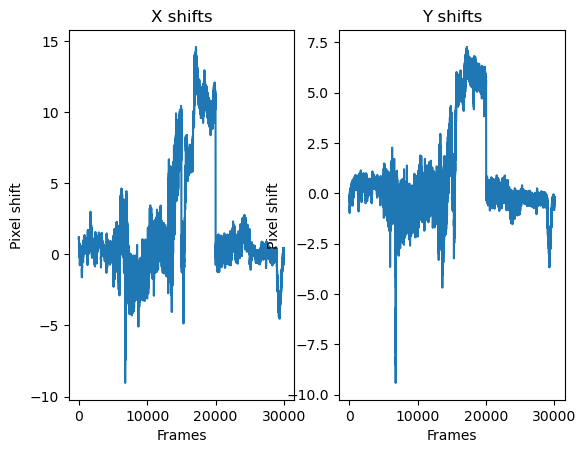

In [29]:
T = len(cnm.estimates.shifts) #Calculated shifts
    
#Get x and y shifts
shifts = cnm.estimates.shifts[-T:]
if (pw_rigid is True):
    y_shifts = [[sx[1] for sx in sh] for sh in shifts]
    x_shifts = [[sx[0] for sx in sh] for sh in shifts]

else:
    y_shifts = [sh[1] for sh in shifts]
    x_shifts = [sh[0] for sh in shifts]
    
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(x_shifts)
ax1.set(title = 'X shifts', xlabel = 'Frames', ylabel = 'Pixel shift')
ax2.plot(y_shifts)
ax2.set(title = 'Y shifts', xlabel = 'Frames', ylabel = 'Pixel shift')

In [ ]:
# Open movies to verify if motion correction went well 

input_movie = mescore.movie_readers.default_reader(fnames[0])
MC_movie = mescore.movie_readers.default_reader(MCfnames[0])

In [ ]:
mcorr_iw = ImageWidget(
    data=[input_movie, MC_movie], 
    vmin_vmax_sliders=True, 
    cmap="gray"
)
mcorr_iw.show()

# Background removal

In [30]:
Denoisedfnames = MCfnames.copy()

for i in range(0,len(MCfnames)):
    Denoisedfnames[i] = volpy.pre_processing.voltage_preprocessing(Denoisedfnames[i])

     3884309 [pre_processing.py:voltage_preprocessing():131] [20292] Background removal of  Z:/Data for optimizing Volpy/Positive dye/pAceR_500Hz_30mW_-2512+222-104_4x4binning_1\MC Results\pAceR_500Hz_30mW_-2512+222-104_4x4binning_1_MMStack_Default_MC.tif
100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.01s/it]
     3888494 [pre_processing.py:voltage_preprocessing():155] [20292] Spline background removal done
     3888844 [pre_processing.py:voltage_preprocessing():162] [20292] Median detrending done
     3889297 [pre_processing.py:voltage_preprocessing():131] [20292] Background removal of  Z:/Data for optimizing Volpy/Positive dye/pAceR_500Hz_30mW_-2512+222-104_5\MC Results\pAceR_500Hz_30mW_-2512+222-104_5_MMStack_Default_MC.tif
100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.66s/it]
     3904356 [pre_processing.py:voltage_preprocessing():155] [20292] Spline ba

## Get Neurons

### Select ROIs through the volpy GUI

In [31]:
%run C:/Users/Gebruiker/mambaforge/envs/caimanRui/Lib/site-packages/caiman/source_extraction/volpy/volpy_gui

tree changes:
<ActionParameter 'LOAD DATA' at 0x1feb4a21ea0>
activated
None
tree changes:
<ActionParameter 'ADD' at 0x1feb4a22200>
activated
None
Saving
Z:/Data for optimizing Volpy/Negative dye/ROIs_7mW.hdf5


     4200328 [timeseries.py:                save():288] [20292] No file saved


tree changes:
<ActionParameter 'SAVE' at 0x1feb4a220e0>
activated
None
tree changes:
<ActionParameter 'LOAD DATA' at 0x1feb4a21ea0>
activated
None
tree changes:
<ActionParameter 'CLEAR' at 0x1feb4a22560>
activated
None
tree changes:
<ActionParameter 'REMOVE' at 0x1feb4a22320>
activated
None
tree changes:
<ActionParameter 'CLEAR' at 0x1feb4a22560>
activated
None
tree changes:
<ActionParameter 'ADD' at 0x1feb4a22200>
activated
None
tree changes:
<ActionParameter 'REMOVE' at 0x1feb4a22320>
activated
None
tree changes:
<ActionParameter 'ADD' at 0x1feb4a22200>
activated
None
Saving
Z:/Data for optimizing Volpy/Negative dye/ROIs_15mW_1.hdf5


     4248207 [timeseries.py:                save():288] [20292] No file saved


tree changes:
<ActionParameter 'SAVE' at 0x1feb4a220e0>
activated
None
tree changes:
<ActionParameter 'LOAD DATA' at 0x1feb4a21ea0>
activated
None
Saving
Z:/Data for optimizing Volpy/Negative dye/ROIs_15mW_2.hdf5


     4271078 [timeseries.py:                save():288] [20292] No file saved


tree changes:
<ActionParameter 'SAVE' at 0x1feb4a220e0>
activated
None
tree changes:
<ActionParameter 'LOAD DATA' at 0x1feb4a21ea0>
activated
None
tree changes:
<ActionParameter 'REMOVE' at 0x1feb4a22320>
activated
None
tree changes:
<ActionParameter 'ADD' at 0x1feb4a22200>
activated
None
Saving
Z:/Data for optimizing Volpy/Negative dye/ROIs_30mW_1.hdf5


     4295108 [timeseries.py:                save():288] [20292] No file saved


tree changes:
<ActionParameter 'SAVE' at 0x1feb4a220e0>
activated
None
tree changes:
<ActionParameter 'LOAD DATA' at 0x1feb4a21ea0>
activated
None
tree changes:
<ActionParameter 'REMOVE' at 0x1feb4a22320>
activated
None
tree changes:
<ActionParameter 'ADD' at 0x1feb4a22200>
activated
None
Saving
Z:/Data for optimizing Volpy/Negative dye/ROIs_30mW_2.hdf5


     4320431 [timeseries.py:                save():288] [20292] No file saved


tree changes:
<ActionParameter 'SAVE' at 0x1feb4a220e0>
activated
None
tree changes:
<ActionParameter 'LOAD DATA' at 0x1feb4a21ea0>
activated
None
tree changes:
<ActionParameter 'REMOVE' at 0x1feb4a22320>
activated
None
tree changes:
<ActionParameter 'ADD' at 0x1feb4a22200>
activated
None
Saving
Z:/Data for optimizing Volpy/Negative dye/ROIs_15mW_1000Hz.hdf5


     4349503 [timeseries.py:                save():288] [20292] No file saved


tree changes:
<ActionParameter 'SAVE' at 0x1feb4a220e0>
activated
None
tree changes:
<ActionParameter 'LOAD DATA' at 0x1feb4a21ea0>
activated
None
tree changes:
<ActionParameter 'REMOVE' at 0x1feb4a22320>
activated
None
tree changes:
<ActionParameter 'ADD' at 0x1feb4a22200>
activated
None
Saving
Z:/Data for optimizing Volpy/Positive dye/ROIs_1x1binning_1.hdf5


     4384816 [timeseries.py:                save():288] [20292] No file saved


tree changes:
<ActionParameter 'SAVE' at 0x1feb4a220e0>
activated
None
tree changes:
<ActionParameter 'LOAD DATA' at 0x1feb4a21ea0>
activated
None
tree changes:
<ActionParameter 'REMOVE' at 0x1feb4a22320>
activated
None
tree changes:
<ActionParameter 'ADD' at 0x1feb4a22200>
activated
None
Saving
Z:/Data for optimizing Volpy/Positive dye/ROIs_1x1binning_2.hdf5


     4407978 [timeseries.py:                save():288] [20292] No file saved


tree changes:
<ActionParameter 'SAVE' at 0x1feb4a220e0>
activated
None
tree changes:
<ActionParameter 'LOAD DATA' at 0x1feb4a21ea0>
activated
None
tree changes:
<ActionParameter 'REMOVE' at 0x1feb4a22320>
activated
None
tree changes:
<ActionParameter 'ADD' at 0x1feb4a22200>
activated
None
Saving
Z:/Data for optimizing Volpy/Positive dye/ROIs_2x2binning_1.hdf5


     4428050 [timeseries.py:                save():288] [20292] No file saved


tree changes:
<ActionParameter 'SAVE' at 0x1feb4a220e0>
activated
None
tree changes:
<ActionParameter 'LOAD DATA' at 0x1feb4a21ea0>
activated
None
tree changes:
<ActionParameter 'REMOVE' at 0x1feb4a22320>
activated
None
tree changes:
<ActionParameter 'ADD' at 0x1feb4a22200>
activated
None
Saving
Z:/Data for optimizing Volpy/Positive dye/ROIs_2x2binning_2.hdf5


     4451783 [timeseries.py:                save():288] [20292] No file saved


tree changes:
<ActionParameter 'SAVE' at 0x1feb4a220e0>
activated
None
tree changes:
<ActionParameter 'LOAD DATA' at 0x1feb4a21ea0>
activated
None
tree changes:
<ActionParameter 'REMOVE' at 0x1feb4a22320>
activated
None
tree changes:
<ActionParameter 'ADD' at 0x1feb4a22200>
activated
None
Saving
Z:/Data for optimizing Volpy/Positive dye/ROIs_4x4binning_1.hdf5


     4470113 [timeseries.py:                save():288] [20292] No file saved


tree changes:
<ActionParameter 'SAVE' at 0x1feb4a220e0>
activated
None
tree changes:
<ActionParameter 'LOAD DATA' at 0x1feb4a21ea0>
activated
None
tree changes:
<ActionParameter 'REMOVE' at 0x1feb4a22320>
activated
None
tree changes:
<ActionParameter 'ADD' at 0x1feb4a22200>
activated
None
Saving
Z:/Data for optimizing Volpy/Positive dye/ROIs_4x4binning_2.hdf5


     4485741 [timeseries.py:                save():288] [20292] No file saved


tree changes:
<ActionParameter 'SAVE' at 0x1feb4a220e0>
activated
None


## Set parameters for VOLPY

In [ ]:
# create summary images
save = True

for i in range(0,len(Denoisedfnames)): 
    
    gui_ROIs = os.path.join(os.path.dirname(Denoisedfnames[i]), 'ROIs.hdf5')
    with h5py.File(gui_ROIs, 'r') as fl:
        ROIs = fl['mov'][()]
          
    ROIs = ROIs                                   # region of interests
    index = list(range(len(ROIs)))                # index of neurons
    weights = None                                # if None, use ROIs for initialization; to reuse weights check reuse weights block 

    template_size = 0.02                          # half size of the window length for spike templates, default is 20 ms 
    context_size = 70                             # number of pixels surrounding the ROI to censor from the background PCA
    visualize_ROI = True                         # whether to visualize the region of interest inside the context region
    flip_signal = True                            # Important!! Flip signal or not, True for Voltron indicator, False for others
    hp_freq_pb = 1 / 3                            # parameter for high-pass filter to remove photobleaching
    clip = 100                                    # maximum number of spikes to form spike template
    threshold_method = 'adaptive_threshold'       # adaptive_threshold or simple 
    min_spikes= 10                                # minimal spikes to be found
    pnorm = 0.5                                   # a variable deciding the amount of spikes chosen for adaptive threshold method
    threshold = 3                                 # threshold for finding spikes only used in simple threshold method, Increase the threshold to find less spikes
    do_plot = True                               # plot detail of spikes, template for the last iteration
    ridge_bg= 0.01                                # ridge regression regularizer strength for background removement, larger value specifies stronger regularization 
    sub_freq = 10                                 # frequency for subthreshold extraction
    weight_update = 'ridge'                       # ridge or NMF for weight update
    n_iter = 2                                    # number of iterations alternating between estimating spike times and spatial filters
    nPC_bg = 8                                    # number of principal components from the background to remove from trace
    
    opts_dict={'fnames': Denoisedfnames[i],
               'fr': fr,
               'ROIs': ROIs,
               'index': index,
               'weights': weights,
               'template_size': template_size, 
               'context_size': context_size,
               'visualize_ROI': visualize_ROI, 
               'flip_signal': flip_signal,
               'hp_freq_pb': hp_freq_pb,
               'clip': clip,
               'threshold_method': threshold_method,
               'min_spikes':min_spikes,
               'pnorm': pnorm, 
               'threshold': threshold,
               'do_plot':do_plot,
               'ridge_bg':ridge_bg,
               'sub_freq': sub_freq,
               'weight_update': weight_update,
               'n_iter': n_iter,
               'nPC_bg': nPC_bg}

    opts = volparams(params_dict=opts_dict)
                                                
    vpy = VOLPY(n_processes=1, dview=None, params=opts)
    vpy.fit(n_processes=1, dview=None)
    
    # Show final output
    img = np.mean(cm.load(Denoisedfnames[i], subindices = slice(0,500,1)),0)
    #bwexp = dilation(ROIs[i], np.ones([vpy.params.volspike.get('context_size'),
    #                     vpy.params.volspike.get('context_size')]), shift_x=True, shift_y=True)
    Xinds = np.where(np.any(ROIs[0] > 0, axis=1) > 0)[0]
    Yinds = np.where(np.any(ROIs[0] > 0, axis=0) > 0)[0]
    img = img[Xinds[0]:Xinds[-1] + 1, Yinds[0]:Yinds[-1] + 1]
    
    utils.view_components(vpy.estimates, img,[int(0)])
    
    if save == True:
        np.save(os.path.join(os.path.dirname(Denoisedfnames[i]), 'Neurons_traces'), vpy.estimates)


In [ ]:
3#
#vpy = np.load(os.path.join(os.path.dirname(Denoisedfnames[0]), 'Neurons_traces.npy'), allow_pickle=True)

#print(vpy.estimates.get('ts'))
#print(vpy)
#plt.plot(vpy.estimates.get('ts')[0])
#plt.plot(vpy.estimates.get('t_rec')[0])
#plt.plot(vpy.estimates.get('t_sub')[0])